In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from dtw import *
from collections import defaultdict
from itertools import combinations, product
from pprint import pprint
import time 
import pickle

%matplotlib inline

print("> All necessary modules imported")

> All necessary modules imported


In [2]:
def _signature_properties(windows):
    """
    Compute the features (x, y, vx, vy, pressure) of the given window
    """
    signatures = []
    
    for iteration, window in enumerate(windows):
        line = window.split(" ")
        # Purpose of line[6] ? --> it removes the \n of each line
        line[6] = line[6].strip()
        
        # Get the values used to compute the features of each window        
        t, x, y, pressure = [float(val) for val in line[:4]]
        
        # If first iteration -> delta = 0
        if iteration==0:
            vx = 0.0
            vy = 0.0
        else:
            prev_t, prev_x, prev_y = previous_txy
            vx = float((x - prev_x) / (t - prev_t))
            vy = float((y - prev_y) / (t - prev_t))
            
        # Store the previous values of the time, the x and y coordinatees to compute vx, vy at next iteration
        previous_txy = (t, x, y)
        signatures.append([x, y, vx, vy, pressure])     
    return np.asarray(signatures)


def storeSignaturesFeaturesOfEachAuthor(authorsFile, allSignaturesFolder):
    """
    Store features of genuine signatures for each writer --> Each writer has 5 genuine signatures
    """
    # Open the file containing all authors and store them in a list
    with open(authorsFile, 'r') as f:
        authorsList = [line.split(" ")[0].strip()
                       for line in f.readlines()]
    
    authorSignatures = defaultdict(list)
    nb_signatures_per_author = 5
    
    # Open each signature file for all authors
    for author, i in product(authorsList, range(nb_signatures_per_author)):
        signatureList = []
        filename = f"{allSignaturesFolder}{author}-g-0{i+1}.txt"
        
        with open(filename, "r") as signature:
            
            # Get all windows of the signatures
            windows = signature.readlines()
            
            # Compute the features vector of the signature
            signatureFeatures = _signature_properties(windows)
            
            # Append the features vector to the dictionary
            authorSignatures[author].append(signatureFeatures)
            
    return authorSignatures   
                    
allGenuineSignatures = storeSignaturesFeaturesOfEachAuthor("./users2.txt", "./enrollment2/")
print("> All features of all genuine signatures for each writer stored")

> All features of all genuine signatures for each writer stored


In [3]:
def storeVerificationSignature(verificationSignaturesFolder):
    """
    Load verification data: 45 signatures per writer, 20 genuine and 25 forgeries
    """
    authorSignatures = defaultdict(list)
    
    # Open all files of the given directory
    for fileName in os.listdir(verificationSignaturesFolder):
        with open(verificationSignaturesFolder+fileName, "r") as signature:
            # Get all windows of the opened signature
            windows = signature.readlines()
        
        # Compute the features vector of the given signatures    
        signatureList = _signature_properties(windows)
        
        # Compute the k=author_name and append the features vector to the list of the chosen author
        author_name, *_ = fileName.replace(".txt", "").split("-")
        authorSignatures[author_name].append(signatureList)
        
    return authorSignatures

verificationSignatures = storeVerificationSignature("./verification2/")
print("> All features of all verification signatures for each writer stored")
    

> All features of all verification signatures for each writer stored


In [4]:
# Compute the average distance between all genuine signatures for each writer
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from itertools import combinations

def _normalize_size(signature, diff):
    """
    Add zeros at the end of the given signature. Used to normalize
    the signature size for the mean distance computation.
    """
    extra_zeros = np.zeros((np.abs(diff), 5))
    
    return np.concatenate((signature, extra_zeros), axis=0)

def _compute_dist(signature_a, signature_b):
    """
    Compute the DTW distance
    """
    diff_length = len(signature_a) - len(signature_b)
            
    if diff_length > 0:
        signature_b = _normalize_size(signature_b, diff_length)
    elif diff_length < 0:
        signature_a = _normalize_size(signature_a, diff_length)
    
    dist = sakoeChibaDTW(signature_a, signature_b, 50)
    
    return dist

def meanDistance(allGenuineSignatures):
    """
    Compute the mean distance between all genuine signature of each author
    """
    meanDistanceForEachAuthor = {}
    for author, signatures in allGenuineSignatures.items():
        allDistances = [_compute_dist(sign_a, sign_b)
                        for sign_a, sign_b
                        in combinations(signatures, 2)]
        
        meanDistanceForEachAuthor[author] = np.mean(allDistances)
    return meanDistanceForEachAuthor

meanDistanceForEachAuthor = meanDistance(allGenuineSignatures)
print("The mean distance of all genuine signatures for each author has been created")


    
            


The mean distance of all genuine signatures for each author has been created


In [5]:
def computeAllDistance(genuineSignatures, testSignatures):
    """
    Compute the mean distance between to all genuine signatures for each test signature of each author
    """
    
    # dictionary {author:[meanTestSignature1WithAllGenuine, meanTestSignature2WithAllGenuine, ...]}
    # Important: the order in the list corresponds to signature1, signature 2, signature3, etc..
    meanPerTestSignature = {}
    for author in testSignatures.keys():
        print("> Start author: ", author)
        start_time = time.perf_counter()
        meanPerTestSignature[author] = []
        for index, testSignature in enumerate(testSignatures[author]):
            dists = []
            start_time2 = time.perf_counter()
            
            # Compute the distance from one test signature to the 5 genuine of the author
            for genuineSignature in genuineSignatures[author]:
                dists.append(sakoeChibaDTW(testSignature, genuineSignature, 50))
                
            # Compute the mean distance
            meanDist = np.mean(dists)
            meanPerTestSignature[author].append(meanDist)
            print(">> Mean distance from the test signature", index,"to the 5 genuine signatures computed in", float(time.perf_counter()-start_time2),"[s]")
        print("> All distances for all signatures of this author computed in", float(time.perf_counter()-start_time),"[s]")

    return meanPerTestSignature
            
        
allMeanDistances = computeAllDistance(allGenuineSignatures, verificationSignatures)
print(allMeanDistances)
            
        

> Start author:  078
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 24.885540260002017 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 14.785330875994987 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 3.5221114690066315 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 3.0974888060009107 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 2.541042594006285 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 8.411148133003735 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 6.038963161001448 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 5.054961873000138 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 2.6694508920045337 [s]
>> Mean distance from the tes

>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 2.1696864270052174 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 2.0453922049928224 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 1.9537943009927403 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 3.561297676002141 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 3.135549809987424 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 2.1517388739885064 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 2.043042732999311 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 6.868137400000705 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 5.219399247987894 [s]
>> Mean distance from the test signature 4

>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.482757516001584 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 4.609125300004962 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 7.7908112480072305 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 3.701346108005964 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 1.0893873759923736 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 6.091478589994949 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 1.1053002499975264 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 5.514716004996444 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 10.606738750997465 [s]
>> Mean distance from the test signature 2

>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 1.1658818880096078 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 2.1142286989925196 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 2.8436795150046237 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 1.1445448129961733 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 2.2199828150041867 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 1.5627277260064147 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 3.0770048559934366 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 1.0601242699922295 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 1.230049357007374 [s]
>> Mean distance from the test signature 13 

>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 11.821885141005623 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 11.238797705009347 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 11.998028887988767 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 13.061688090994721 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 11.763710303988773 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 14.840278706993558 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 13.276472361991182 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 11.90549525199458 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 11.717278518000967 [s]
>> Mean distance from the test signatu

>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 1.0132382449955912 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 0.9768601940013468 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 0.9695878399943467 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 3.312635861002491 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 1.1046266019984614 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 2.9443171879975125 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 1.1057640599901788 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 0.8939547890040558 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 1.2146065949928015 [s]
>> Mean distance from the test signatu

>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 3.9746430149971275 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 12.302303301999927 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 2.089981765006087 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 2.873136636990239 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 2.5695455270033563 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 3.251965798001038 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 3.170353225999861 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 2.420347381004831 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 12.9896086200024 [s]
>> Mean distance from the test signature 16 to 

>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 9.447118508003769 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 4.78438567899866 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 3.8058373269886943 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 8.789834622002672 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 3.663875640995684 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 2.8927646660013124 [s]
> All distances for all signatures of this author computed in 281.8853762560029 [s]
> Start author:  066
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 1.4667225320008583 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 1.6370749570050975 [s]
>> Mean distance from the test signature 2 to 

>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 4.390399199997773 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 5.1687656519934535 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 1.6568039970006794 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 4.452663659991231 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 3.5919251530140173 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 1.609602527023526 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 1.5606834989739582 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 2.623481290997006 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 4.127293764991919 [s]
>> Mean distance from the test signature 3

>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 1.5031928940152284 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 1.7637616749852896 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 1.9868383599969093 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 2.23261420201743 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 2.0502816200023517 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 1.6209589280188084 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 3.9611626360274386 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 5.436212770000566 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.886928338004509 [s]
>> Mean distance from the test signature 

>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 6.137571061000926 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 5.956232540018391 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 22.914661922986852 [s]
> All distances for all signatures of this author computed in 298.15785502499784 [s]
> Start author:  091
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 1.7495231670036446 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 1.8746791190060321 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 8.404830287006916 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 1.959958106977865 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 8.451339861989254 [s]
>> Mean distance from the test signature 5 to th

>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 3.0238192809920292 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 3.6312933879962657 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 2.935222012019949 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 2.853722254978493 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 16.15721353702247 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 2.666815370990662 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 3.4524165809853002 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 3.7010098890168592 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 20.08132879200275 [s]
>> Mean distance from the test signature 3

>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 2.732418774976395 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 2.8442512470064685 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 2.687548308982514 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 14.25755022498197 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 2.8003590669832192 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 3.0458946470171213 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 2.612166064005578 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 2.6342983549984638 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 11.989099183003418 [s]
>> Mean distance from the test signature 

>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 2.227341041987529 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 1.7429156780126505 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 2.1593139309843536 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 2.0464964939747006 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 1.8737378920195624 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 1.9233667700027581 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 1.7673681279993616 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 1.897996192012215 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 1.9750007069960702 [s]
>> Mean distance from the test signature 9 to th

>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 4.101944074005587 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 1.2925687360111624 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 1.3751181529951282 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 4.439058926014695 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 1.2620683669811115 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 1.5487552169943228 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 1.351843240991002 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 1.5362191330059431 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 1.3350946239952464 [s]
>> Mean distance from the test signature

>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 4.117615483992267 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 10.938680144987302 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 4.264231814013328 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 4.115547966008307 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 4.85868525999831 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 4.0475394769746345 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 14.441412448999472 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 12.846025189006468 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 8.565870919002919 [s]
>> Mean distance from the test signature 27

>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 3.0407123469922226 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 2.3580719440069515 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 2.372970085009001 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 6.267002545995638 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 13.742029326996999 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 19.66620935301762 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 4.961291298008291 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 2.329826190980384 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 2.2053042229963467 [s]
>> Mean distance from the test signature 13 to t

>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 4.877873188990634 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 3.039296100003412 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 5.436326567985816 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 0.8689863030158449 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 3.446338506997563 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 0.9437743820017204 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 0.9284404469945002 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 1.1389973710174672 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 1.3310738900036085 [s]
> All distances for all signatures of thi

>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 19.14480392698897 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 29.32243624900002 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 4.261440872011008 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 6.842504052008735 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 4.498105014004977 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 3.53354858601233 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 28.42052557002171 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 23.837631702015642 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 34.70666473399615 [s]
>> Mean distance from the test signature 31 to

>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 1.6209140039863996 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 1.3858981759985909 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 4.1314873170049395 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 2.4508538710069843 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 1.3940444689942524 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 3.872142478998285 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 1.2937701799964998 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 5.190234315989073 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 3.838915883010486 [s]
>> Mean distance from the test signature 1

>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 26.89613029899192 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 7.512886559998151 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 11.091529102995992 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 16.51824310401571 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 4.774866394989658 [s]
> All distances for all signatures of this author computed in 597.2276193040016 [s]
> Start author:  040
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 9.372461443010252 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 4.654765854997095 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 3.918050801992649 [s]
>> Mean distance from the test signature 3 to the

>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 6.737473929999396 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 34.74763346699183 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 6.499597379995976 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 32.65698913301458 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 6.765339942998253 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 10.230093161022523 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 7.003854359005345 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 13.907225817005383 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 7.446060220012441 [s]
>> Mean distance from the test signature 35 

>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 18.17046427601599 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 3.5942396220052615 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 3.4292404799780343 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 5.924242092994973 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 3.7192687740025576 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 4.555601843982004 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 4.721051764005097 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 3.953764292993583 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 22.55331811698852 [s]
>> Mean distance from the test signature 21

>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 0.8973947610065807 [s]
> All distances for all signatures of this author computed in 81.76498015300604 [s]
> Start author:  059
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 5.348435794003308 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 1.5294049069925677 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 7.255715945997508 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 3.6269636990036815 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 1.5415611889911816 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 1.6704795900150202 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 10.762740625010338 [s]
>> Mean distance from the test signature 7 to th

>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 7.1804474650125485 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 9.136917906987946 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 4.499652036000043 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 4.9047270430019125 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 9.456401675997768 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 12.573792770010186 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 3.6024678020039573 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 5.359529124980327 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 3.4358572229975834 [s]
>> Mean distance from the test signature 

>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 3.0350989350117743 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 3.5715935140033253 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 3.2697499039932154 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 3.3383197149960324 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 16.890966392995324 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 19.087788942008046 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 3.2102534500008915 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 3.2840616820030846 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 3.4265232580073643 [s]
>> Mean distance from the test signat

>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 1.8853075570077635 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 1.7417264890100341 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 8.515423342993017 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 9.433284405997256 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 2.176264979003463 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 4.431026653008303 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 1.6522479639970697 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 1.925160398997832 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 6.510405320994323 [s]
>> Mean distance from the test signature 11 to the 

>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 1.2341550089768134 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 1.2267184910015203 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 2.965403349022381 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 1.2458951210137457 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 1.4937339579919353 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 3.680275595979765 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 3.7272199809958693 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 1.3361745090223849 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 3.0795413170126267 [s]
>> Mean distance from the test signatur

>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 0.24072936698212288 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 0.2014266129990574 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 0.2569981040142011 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 0.17858752101892605 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 0.1715277400217019 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 0.17649632698157802 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 0.21257899500778876 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 0.2958769940014463 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 0.19602743699215353 [s]
>> Mean distance from the test s

>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 1.0952456640079618 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 0.595040862011956 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 0.7252562349895015 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 1.1628128010197543 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 0.9254982050042599 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 1.3615838130062912 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 1.0939415320171975 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 0.9291443849797361 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 1.5292715550167486 [s]
>> Mean distance from the test signature 13 

>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 2.59169133901014 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 1.3992452420061454 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 1.5497656670049764 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 1.7617943809891585 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 1.6543148230121005 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 1.7714605549990665 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 2.3237448090221733 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 5.751971151999896 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 1.4471228950133082 [s]
>> Mean distance from the test signature

>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 0.851754659001017 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 0.7942717080004513 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 1.767836070008343 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 2.2145987899857573 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 0.8017861340194941 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 0.8437886169995181 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 3.4684764700068627 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 1.6421682080253959 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 3.138065918989014 [s]
>> Mean distance from the test signature

>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 6.017549765994772 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 3.529001349990722 [s]
>> Mean distance from the test signature 9 to the 5 genuine signatures computed in 2.100578522979049 [s]
>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 11.223321741999825 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 1.2669168150168844 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 6.223190521006472 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 2.670290483016288 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 1.9072249000018928 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 4.557947633002186 [s]
>> Mean distance from the test signature 16 to

>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 15.061146576015744 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 9.648364419001155 [s]
>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 5.031309864018112 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 2.3294482759956736 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 4.445780737005407 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 13.673547321988735 [s]
> All distances for all signatures of this author computed in 379.65241940601845 [s]
> Start author:  034
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 6.167034974001581 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 2.931379868008662 [s]
>> Mean distance from the test signature 2 to

>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 6.129947948997142 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 11.922045497980434 [s]
>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 3.5205482519813813 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 7.56952125299722 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 5.87577375600813 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 4.230951704987092 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 13.835375574999489 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 4.678593335003825 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 18.697133183974074 [s]
>> Mean distance from the test signature 34 

>> Mean distance from the test signature 10 to the 5 genuine signatures computed in 1.581515641999431 [s]
>> Mean distance from the test signature 11 to the 5 genuine signatures computed in 1.9810414609964937 [s]
>> Mean distance from the test signature 12 to the 5 genuine signatures computed in 0.884193392994348 [s]
>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 0.9182335509976838 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 1.0864147790125571 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 0.890044696017867 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 1.1421339419903234 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 1.0815939669846557 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.4323667690041475 [s]
>> Mean distance from the test signature

>> Mean distance from the test signature 41 to the 5 genuine signatures computed in 4.3783637970045675 [s]
>> Mean distance from the test signature 42 to the 5 genuine signatures computed in 2.5535729709954467 [s]
>> Mean distance from the test signature 43 to the 5 genuine signatures computed in 1.4751912160136271 [s]
>> Mean distance from the test signature 44 to the 5 genuine signatures computed in 1.4430377059907187 [s]
> All distances for all signatures of this author computed in 124.59523154899944 [s]
> Start author:  062
>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 4.043273938004859 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 3.831715776002966 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 4.488402742979815 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 2.279412923991913 [s]
>> Mean distance from the test signature 4 to 

>> Mean distance from the test signature 27 to the 5 genuine signatures computed in 1.7124022450007033 [s]
>> Mean distance from the test signature 28 to the 5 genuine signatures computed in 1.8557078980084043 [s]
>> Mean distance from the test signature 29 to the 5 genuine signatures computed in 3.8882685970165767 [s]
>> Mean distance from the test signature 30 to the 5 genuine signatures computed in 4.659260874002939 [s]
>> Mean distance from the test signature 31 to the 5 genuine signatures computed in 13.17383395502111 [s]
>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 13.044363039021846 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 2.515372377994936 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 9.317574231012259 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 2.097911547025433 [s]
>> Mean distance from the test signature 3

>> Mean distance from the test signature 13 to the 5 genuine signatures computed in 1.9308872099791188 [s]
>> Mean distance from the test signature 14 to the 5 genuine signatures computed in 4.33989248299622 [s]
>> Mean distance from the test signature 15 to the 5 genuine signatures computed in 1.846130492980592 [s]
>> Mean distance from the test signature 16 to the 5 genuine signatures computed in 1.9298157249868382 [s]
>> Mean distance from the test signature 17 to the 5 genuine signatures computed in 1.8701097659941297 [s]
>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.7623283799912315 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 1.9379907840047963 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 3.839701161981793 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 1.924213232996408 [s]
>> Mean distance from the test signature 2

>> Mean distance from the test signature 0 to the 5 genuine signatures computed in 2.273286048992304 [s]
>> Mean distance from the test signature 1 to the 5 genuine signatures computed in 4.6557666920125484 [s]
>> Mean distance from the test signature 2 to the 5 genuine signatures computed in 5.122820226009935 [s]
>> Mean distance from the test signature 3 to the 5 genuine signatures computed in 2.1636321650003083 [s]
>> Mean distance from the test signature 4 to the 5 genuine signatures computed in 1.9579390099970624 [s]
>> Mean distance from the test signature 5 to the 5 genuine signatures computed in 2.081273310992401 [s]
>> Mean distance from the test signature 6 to the 5 genuine signatures computed in 2.575308914994821 [s]
>> Mean distance from the test signature 7 to the 5 genuine signatures computed in 2.0033822619880084 [s]
>> Mean distance from the test signature 8 to the 5 genuine signatures computed in 1.888182004011469 [s]
>> Mean distance from the test signature 9 to the 5

>> Mean distance from the test signature 32 to the 5 genuine signatures computed in 0.763908705994254 [s]
>> Mean distance from the test signature 33 to the 5 genuine signatures computed in 0.779478273994755 [s]
>> Mean distance from the test signature 34 to the 5 genuine signatures computed in 0.998416169983102 [s]
>> Mean distance from the test signature 35 to the 5 genuine signatures computed in 1.9174696679983754 [s]
>> Mean distance from the test signature 36 to the 5 genuine signatures computed in 0.7517676419811323 [s]
>> Mean distance from the test signature 37 to the 5 genuine signatures computed in 1.1748424340039492 [s]
>> Mean distance from the test signature 38 to the 5 genuine signatures computed in 0.7362321649852674 [s]
>> Mean distance from the test signature 39 to the 5 genuine signatures computed in 0.80219776899321 [s]
>> Mean distance from the test signature 40 to the 5 genuine signatures computed in 1.33162325801095 [s]
>> Mean distance from the test signature 41 

>> Mean distance from the test signature 18 to the 5 genuine signatures computed in 1.9735696150164586 [s]
>> Mean distance from the test signature 19 to the 5 genuine signatures computed in 2.210337139025796 [s]
>> Mean distance from the test signature 20 to the 5 genuine signatures computed in 9.768007026985288 [s]
>> Mean distance from the test signature 21 to the 5 genuine signatures computed in 2.3739538920053747 [s]
>> Mean distance from the test signature 22 to the 5 genuine signatures computed in 6.937053144996753 [s]
>> Mean distance from the test signature 23 to the 5 genuine signatures computed in 11.485821525973734 [s]
>> Mean distance from the test signature 24 to the 5 genuine signatures computed in 2.4504703099955805 [s]
>> Mean distance from the test signature 25 to the 5 genuine signatures computed in 2.1617647640232462 [s]
>> Mean distance from the test signature 26 to the 5 genuine signatures computed in 2.3762339200184215 [s]
>> Mean distance from the test signature

In [6]:
import pickle

def save_obj(obj, name):
    """
    Save the given object in a file
    """
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    print("> Mean distance of all test signatures stored in:", 'obj/' + name + '.pkl')
        
savedData = save_obj(allMeanDistances,"testSignatures2")


> Mean distance of all test signatures stored in: obj/testSignatures2.pkl


In [7]:
def load_obj(name ):
    """
    Retrieve the object contained in the given file
    """
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
data = load_obj("testSignatures2")
print("> Mean distance of all test signatures retrieved")

> Mean distance of all test signatures retrieved


In [15]:
def predict(testSignatures):
    """
    Predict the class of all verification signature
    """
    thresholds = [i for i in range(0, 50000, 50)]
    #thresholds = [10000]
    prediction = {}
    for threshold in thresholds:
        prediction[threshold]={}
        for author in testSignatures.keys():
            for index,signature in enumerate(testSignatures[author]):
                if abs(signature-meanDistanceForEachAuthor[author])<threshold:
                    if index<9:
                        prediction[threshold][str(author)+"-0"+str(index+1)]='g'
                    else:
                        prediction[threshold][str(author)+"-"+str(index+1)]='g'
                else:
                    if index<9:
                        prediction[threshold][str(author)+"-0"+str(index+1)]='f'
                    else:
                        prediction[threshold][str(author)+"-"+str(index+1)]='f'
    return prediction

allPredictions = predict(data)
print("> Prediction successfully done ")

#pprint(allPredictions)
    

> Prediction successfully done 


In [11]:
def evaluate(allPredictions):
    """
    Compute the accuracy of the algorithm using the ground truth
    """
    groundTruth = {}
    accuracy = {}
    with open("gt.txt", "r") as myfile:
        lines = myfile.readlines()
        for l in lines:
            a = l.replace("\n", "").split(" ")
            groundTruth[a[0]] = a[1]
        
    for threshold in allPredictions.keys():
        correct = 0
        wrong = 0
        for signature in allPredictions[threshold].keys():
            if groundTruth[signature]==allPredictions[threshold][signature]:
                correct+=1
            else:
                wrong+=1
        accuracy[threshold]= correct/(correct+wrong)
    return accuracy

accuracyList = evaluate(allPredictions)
print("> Dictionary of accuracy for each threshold generated")
        

KeyError: '078-01'

In [13]:
print(accuracyList)

{0: 0.5555555555555556, 50: 0.5585185185185185, 100: 0.5592592592592592, 150: 0.56, 200: 0.5607407407407408, 250: 0.5622222222222222, 300: 0.5614814814814815, 350: 0.5622222222222222, 400: 0.5637037037037037, 450: 0.5651851851851852, 500: 0.5666666666666667, 550: 0.5688888888888889, 600: 0.5718518518518518, 650: 0.5748148148148148, 700: 0.5792592592592593, 750: 0.5792592592592593, 800: 0.577037037037037, 850: 0.5814814814814815, 900: 0.582962962962963, 950: 0.5844444444444444, 1000: 0.5851851851851851, 1050: 0.5881481481481482, 1100: 0.5911111111111111, 1150: 0.5940740740740741, 1200: 0.5955555555555555, 1250: 0.5955555555555555, 1300: 0.5985185185185186, 1350: 0.5992592592592593, 1400: 0.6007407407407407, 1450: 0.6022222222222222, 1500: 0.6074074074074074, 1550: 0.6081481481481481, 1600: 0.6103703703703703, 1650: 0.6133333333333333, 1700: 0.6148148148148148, 1750: 0.6162962962962963, 1800: 0.6177777777777778, 1850: 0.6192592592592593, 1900: 0.6192592592592593, 1950: 0.6207407407407407

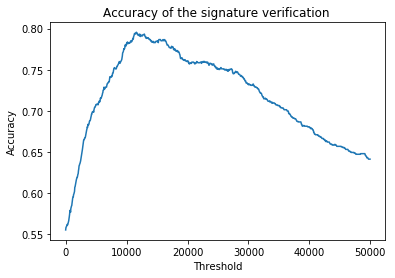

In [23]:
def visualize(accuracy):
    lists = sorted(accuracy.items()) 
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.title("Accuracy of the signature verification ")
    plt.xlabel("Threshold")
    plt.yscale('linear')
    plt.ylabel("Accuracy")
    plt.show()
visualize(accuracyList)

In [26]:
"""Re-arrange data to generate the output"""

def rearrange_data(data):
    # rearranged_data looks like: {authorID: {signatureID: distance}}
    rearranged_data = dict()
    
    for k, v in data.items():
        sub_dict = dict()
        for index, value in enumerate(v):
            sub_dict[str(index+1) if index+1 > 9 else '0' + str(index+1)] = value
        rearranged_data[k] = sub_dict
    return rearranged_data

rearranged_data = rearrange_data(data)
print(rearranged_data)

{'001': {'01': 13001.333166272263, '02': 11908.515575917567, '03': 43409.92617170668, '04': 54717.993599174704, '05': 12353.227673980806, '06': 41630.77439716559, '07': 47866.69401646619, '08': 14417.930715546265, '09': 12082.915756786912, '10': 30563.906886321736, '11': 12562.930793462274, '12': 48137.7766193875, '13': 15334.088776816756, '14': 12048.98721299005, '15': 28884.376938129968, '16': 13928.663978519577, '17': 13748.52724458207, '18': 15037.49686369397, '19': 14929.452795900961, '20': 31322.779500425626, '21': 35244.213478989914, '22': 15689.138296084082, '23': 15780.555239011712, '24': 49070.49807795612, '25': 47274.01406461514, '26': 15752.883828493126, '27': 45304.36049484494, '28': 17214.04924326005, '29': 11564.229849914438, '30': 46885.74099557013, '31': 42007.492896334836, '32': 49115.57821433876, '33': 13932.810638669116, '34': 43237.85881512962, '35': 46553.564243990826, '36': 27962.152250528627, '37': 15614.184148653696, '38': 31891.937756600535, '39': 51067.210667

In [27]:
"""Export results to match the requested output format"""

def export_results(rearranged_data):
    # create output directory if needed
    if not os.path.exists('./Output/'):
        os.makedirs('./Output/')
    
    # generate output
    output_str = ''
    for authorID, distances in rearranged_data.items():
        output_str += '{}'.format(authorID)
        for id, dist in distances.items():
            output_str += ', {}, {}'.format(id, dist)
        output_str += '\n'
        
    output_str = output_str.rstrip() # remove the last \n
    
    # export output
    with open("./Output/output.txt", "w") as output_file:
        output_file.write(output_str)
    
    # print as verification
    print(output_str)


export_results(rearranged_data)

001, 01, 13001.333166272263, 02, 11908.515575917567, 03, 43409.92617170668, 04, 54717.993599174704, 05, 12353.227673980806, 06, 41630.77439716559, 07, 47866.69401646619, 08, 14417.930715546265, 09, 12082.915756786912, 10, 30563.906886321736, 11, 12562.930793462274, 12, 48137.7766193875, 13, 15334.088776816756, 14, 12048.98721299005, 15, 28884.376938129968, 16, 13928.663978519577, 17, 13748.52724458207, 18, 15037.49686369397, 19, 14929.452795900961, 20, 31322.779500425626, 21, 35244.213478989914, 22, 15689.138296084082, 23, 15780.555239011712, 24, 49070.49807795612, 25, 47274.01406461514, 26, 15752.883828493126, 27, 45304.36049484494, 28, 17214.04924326005, 29, 11564.229849914438, 30, 46885.74099557013, 31, 42007.492896334836, 32, 49115.57821433876, 33, 13932.810638669116, 34, 43237.85881512962, 35, 46553.564243990826, 36, 27962.152250528627, 37, 15614.184148653696, 38, 31891.937756600535, 39, 51067.21066703165, 40, 45039.13436596114, 41, 46622.03212497581, 42, 38192.623600299085, 43, 1